## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.



In [2]:
import pandas as pd
import numpy as np
filename = 'data_000637.txt'
full_data = pd.read_csv(filename,skiprows=range(1,1))
data = full_data[:20000]

In [3]:
data.sort_values(by="BX_COUNTER")
sorted_data = (full_data.sort_values(by="ORBIT_CNT")).copy()
sorted_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
24,1,0,58,3869200167,2795,19
25,1,0,62,3869200167,2797,14
26,1,0,59,3869200167,2799,14
27,1,0,59,3869200167,3081,21
...,...,...,...,...,...,...
1310699,1,0,25,3869211171,11,28
1310698,1,0,60,3869211171,9,9
1310718,1,0,139,3869211171,769,0
1310707,1,0,57,3869211171,137,29


2\. Find out the number of BX in a ORBIT (the value 'x').



In [4]:
full_data.apply(lambda x: x.max(axis=0) - x.min(axis=0))

HEAD               0
FPGA               1
TDC_CHANNEL      138
ORBIT_CNT      11004
BX_COUNTER      3563
TDC_MEAS          29
dtype: int64

In [5]:
x = 3563 + 1 # as we can see before
print("x:", x)

x: 3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.



In [6]:
max_orb = full_data[full_data['ORBIT_CNT'] == full_data['ORBIT_CNT'].max(axis=0)]
max_bxc = max_orb[max_orb['BX_COUNTER'] == max_orb['BX_COUNTER'].max(axis=0)] 
max_tdc = max_bxc[max_bxc['TDC_MEAS'] == max_bxc['TDC_MEAS'].max(axis=0)] 
min_orb = full_data[full_data['ORBIT_CNT'] == full_data['ORBIT_CNT'].min(axis=0)]
min_bxc = min_orb[min_orb['BX_COUNTER'] == min_orb['BX_COUNTER'].min(axis=0)] 
min_tdc = min_bxc[min_bxc['TDC_MEAS'] == min_bxc['TDC_MEAS'].min(axis=0)]

In [7]:
def time_subtraction (h1, m1, s1, h2, m2, s2, h_to_m, m_to_s): # function that performs "time" subtraction from hours, min, sec
    dm, dh = 0, 0
    if s1 - s2 < 0:
        dm = -1
        sf = (s1+m_to_s) - s2
    else:
        sf = s1 - s2
    if (m1 + dm) - m2 < 0:
        dh = -1
        mf = (m1+h_to_m) - m2 + dm
    else:
        mf = m1 - m2 + dm
    hf = h1 - h2 + dh
    return hf, mf, sf

In [8]:
orb, bxc, tdc = time_subtraction (max_tdc['ORBIT_CNT'].iloc[0], max_tdc['BX_COUNTER'].iloc[0], max_tdc['TDC_MEAS'].iloc[0], min_tdc['ORBIT_CNT'].iloc[0], min_tdc['BX_COUNTER'].iloc[0], min_tdc['TDC_MEAS'].iloc[0], x, 30)
print((x*25*orb + 25*bxc + 30/25*tdc)*10**(-9), "s")

0.9804162548 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).



In [9]:
full_data['TIME (ns)']=(full_data['TDC_MEAS'] - full_data.iloc[0,full_data.columns.get_loc('TDC_MEAS')])*25/30 + (full_data['BX_COUNTER'] - full_data.iloc[0,full_data.columns.get_loc('BX_COUNTER')])*25+ (full_data['ORBIT_CNT'] - full_data.iloc[0,full_data.columns.get_loc('ORBIT_CNT')])*25*x
full_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.



In [10]:
import random
full_data['HEAD'] = full_data['HEAD'].apply(lambda x : random.randrange(0,2,1))
full_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,0,0,124,3869200167,2374,27,8.333333e-01
2,0,0,63,3869200167,2553,28,4.476667e+03
3,0,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [11]:
new_data = (full_data[full_data['HEAD'] == 1]).copy()
new_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
4,1,0,64,3869200167,2760,25,9.649167e+03
6,1,0,61,3869200167,2772,14,9.940000e+03
7,1,0,139,3869200167,2776,0,1.002833e+04
8,1,0,62,3869200167,2774,21,9.995833e+03
...,...,...,...,...,...,...,...
1310712,1,1,35,3869211171,429,4,9.804078e+08
1310713,1,0,64,3869211171,758,18,9.804160e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

<AxesSubplot:>

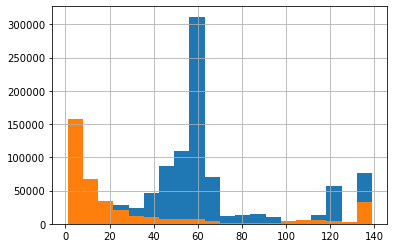

In [12]:
full_data_fpga0 = full_data[full_data['FPGA'] == 0]
full_data_fpga1 = full_data[full_data['FPGA'] == 1]
full_data_fpga0['TDC_CHANNEL'].hist(bins = 20)
full_data_fpga1['TDC_CHANNEL'].hist(bins = 20)

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [13]:
full_data.groupby(['TDC_CHANNEL']).count().sort_values('FPGA').tail(3)

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (ns)
TDC_CHANNEL,,,,,,
63,64642,64642,64642,64642,64642,64642
64,66020,66020,66020,66020,66020,66020
139,108059,108059,108059,108059,108059,108059


In [14]:
full_data['TDC_CHANNEL'].value_counts().head(3) # same answer

139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [15]:
full_data['ORBIT_CNT'].nunique()

11001

In [16]:
subset = full_data[full_data['TDC_CHANNEL'] == 139]
subset['ORBIT_CNT'].nunique()

10976